# GNN Benchmarking for Stock Return Prediction
**2025-10-06**

In [ ]:
!pip install -q nodevectors==0.2.0
!pip install -q networkx==3.5.0
!pip install -q torch-geometric==2.5.3
#!pip install -q torch-geometric-temporal==0.56.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.5.1 which is incompatible.
nx-cugraph-cu12 25.6.0 requires networkx>=3.2, but you have networkx 2.5.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nodevectors 0.2.0 requires networkx==2.5.1, but you have networkx 3.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!cat requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.1
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.20.0.39.8
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.3
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.26.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3

# 1) Imports, config, seeds



In [ ]:
import warnings, math, random, gc
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf
import networkx as nx

from nodevectors import Node2Vec


from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv

#from torch_geometric_temporal.nn.recurrent import EvolveGCNO



# ---------------- CONFIG ----------------
CONFIG = {
  "tickers": [
      # Tech
      "AAPL","MSFT","GOOGL","NVDA","META",
      # Finance
      "JPM","BAC","GS","V","MA",
      # Consumer
      "WMT","COST","DIS","KO","PEP",
      # Healthcare
      "PFE","UNH","JNJ",
      # Energy
      "XOM","CVX",
      # Industrials / Others
      "CAT","HD","MCD","NKE","ORCL","IBM","TXN","INTC","AMZN"
  ],
  "start": "2005-01-01",
  "end":   "2025-01-01",

  # target horizon
  "horizon_days": 5,          # predict next-week up/down

  # graph
  "corr_window": 60,
  "corr_thr": 0.4,

  # splits
  "train_end": "2019-12-31",
  "val_end":   "2020-12-31",

  # eval
  "top_k_frac": 0.10,         # dynamic P@K = 10% per day
  "top_k_abs":  None,

  # models / training
  "epochs_gnn": 15,
  "epochs_lstm": 10,
  "seq_len": 30,
  "hidden_gnn": 64,
  "hidden_lstm": 64,
  "lr": 1e-3,
  "weight_decay": 1e-4,
  "seed": 42
}

SEED = CONFIG["seed"]
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# 2) Data download & core features (shared)

In [ ]:
import yfinance as yf

# ---------- prices ----------
data = yf.download(CONFIG["tickers"], start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)
prices = data["Close"].dropna(how="all")
prices = prices.dropna(axis=1, how="any")
tickers_used = sorted(prices.columns.tolist())
print("Tickers:", len(tickers_used))

# ---------- feature helpers ----------
def compute_returns(prices: pd.DataFrame, lag=1): return prices.pct_change(lag)
def rolling_volatility(returns: pd.DataFrame, window=20): return returns.rolling(window).std()

spy = yf.download("^GSPC", start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)['Close']
spy_ret = spy.pct_change(1)

def rolling_beta(stock_returns: pd.DataFrame, market_returns: pd.Series, window=60):
    cov = stock_returns.rolling(window).cov(market_returns)
    var = market_returns.rolling(window).var()
    return cov.div(var, axis=0)

# ---------- raw features ----------
rets_1d  = compute_returns(prices, 1)
rets_5d  = compute_returns(prices, 5)
rets_21d = compute_returns(prices, 21)
vol_20d  = rolling_volatility(rets_1d, 20)
beta_60d = rolling_beta(rets_1d, spy_ret, 60)
mom_5d   = prices.pct_change(5)  # simple momentum proxy

# ---------- label: next-week up/down ----------
H = CONFIG["horizon_days"]
label_h = (compute_returns(prices, H).shift(-1) > 0).astype(int)

# ---------- stack to (date, ticker) ----------
def stack_features(feat_df, name):
    s = feat_df.stack().rename(name).to_frame()
    s.index.set_names(['date','ticker'], inplace=True)
    return s

feat_frames = []
for name, df in {
    "ret_1d": rets_1d,
    "ret_5d": rets_5d,
    "ret_21d": rets_21d,
    "vol_20d": vol_20d,
    "beta_60d": beta_60d,
    "mom_5d":  mom_5d
}.items():
    f = stack_features(df, name)
    feat_frames.append(f)

X = pd.concat(feat_frames, axis=1).dropna(how="all").fillna(0)
y = stack_features(label_h, "label").reindex(X.index).dropna()
X = X.loc[y.index]

# Cross-sectional z-score per day
X_z = X.groupby(level='date').transform(lambda col: (col - col.mean())/(col.std(ddof=0)+1e-9))

# drop early history to stabilize rolling stats
MIN_HISTORY = max(CONFIG["corr_window"], 80)
valid_dates = prices.index[MIN_HISTORY:]
X_z = X_z.loc[X_z.index.get_level_values('date').isin(valid_dates)]
y   = y.loc[X_z.index]

print("Final shapes:", X_z.shape, y.shape)


Tickers: 26
Final shapes: (128778, 6) (128778, 1)


# 3) Split by time (no leakage)

In [ ]:
dates = X_z.index.get_level_values('date')
train_mask = dates <= pd.to_datetime(CONFIG["train_end"])
val_mask   = (dates > pd.to_datetime(CONFIG["train_end"])) & (dates <= pd.to_datetime(CONFIG["val_end"]))
test_mask  = dates > pd.to_datetime(CONFIG["val_end"])

X_train, y_train = X_z[train_mask], y[train_mask]
X_val,   y_val   = X_z[val_mask],   y[val_mask]
X_test,  y_test  = X_z[test_mask],  y[test_mask]

len(X_train), len(X_val), len(X_test)


(96070, 6578, 26130)

# 4) Evaluation helpers (robust, dynamic P@K)

In [ ]:
TOP_K_FRAC = CONFIG["top_k_frac"]
TOP_K_ABS  = CONFIG["top_k_abs"]

def _resolve_k(n):
    if TOP_K_ABS is not None: k = TOP_K_ABS
    elif TOP_K_FRAC is not None: k = max(1, int(round(TOP_K_FRAC*n)))
    else: k = max(1, int(round(0.1*n)))
    return min(k, max(1,n))

def precision_at_k(scores: np.ndarray, labels: np.ndarray, k: int) -> float:
    mask = ~np.isnan(scores) & ~np.isnan(labels)
    s = scores[mask].astype(float); y = labels[mask].astype(int)
    n = len(s); k = min(max(1,k), n)
    if n == 0 or k == 0: return np.nan
    idx = np.argsort(-s, kind="mergesort")[:k]
    return float(np.mean(y[idx]))

def daily_metric_aggregate(df_scores: pd.DataFrame) -> pd.Series:
    rows = []
    for d, sub in df_scores.groupby('date'):
        y = sub['label'].to_numpy()
        s = sub['score'].to_numpy()
        y_hat = (s >= 0.5).astype(int)
        acc = accuracy_score(y, y_hat) if len(np.unique(y))>=1 else np.nan
        auc = roc_auc_score(y, s) if len(np.unique(y))>1 else np.nan
        f1  = f1_score(y, y_hat)  if len(np.unique(y))>1 else np.nan
        k   = _resolve_k(len(sub))
        p_at_k = precision_at_k(s, y, k)
        rows.append((d, acc, auc, f1, p_at_k))
    out = pd.DataFrame(rows, columns=['date','acc','auc','f1','p_at_k']).set_index('date')
    return out.mean(skipna=True)


# 5) Tabular baselines (LogReg, XGBoost)

In [ ]:
def evaluate_tabular_model(model, X_df, y_arr):
    dates = X_df.index.get_level_values("date")
    scores = model.predict_proba(X_df.values)[:,1]
    tmp = pd.DataFrame({"date": dates.values, "score": scores, "label": y_arr.astype(float)})
    return daily_metric_aggregate(tmp)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', n_jobs=-1)
lr.fit(X_train.values, y_train.values.ravel())
lr_test = evaluate_tabular_model(lr, X_test, y_test.values.ravel())

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method='hist', random_state=SEED
)
xgb.fit(X_train.values, y_train.values.ravel(),
        eval_set=[(X_val.values, y_val.values.ravel())],
        verbose=False)
xgb_test = evaluate_tabular_model(xgb, X_test, y_test.values.ravel())

print("LogReg TEST:\n", lr_test)
print("XGBoost TEST:\n", xgb_test)


LogReg TEST:
 acc       0.724914
auc       0.892359
f1        0.736651
p_at_k    0.905473
dtype: float64
XGBoost TEST:
 acc       0.723804
auc       0.880276
f1        0.736812
p_at_k    0.895522
dtype: float64


# 6) LSTM (shared model across stocks)

In [ ]:
# Build per-stock sequences: (seq_len, feat_dim) -> label (next-week up/down)
SEQ_LEN = CONFIG["seq_len"]

# Prepare panel (date x ticker x features)
panel = X_z.reset_index().pivot(index='date', columns='ticker', values=X_z.columns.tolist())
# panel has MultiIndex columns (feature, ticker) or vice versa. We'll reformat:

# Easier: build sequences ticker-by-ticker
feat_cols = X_z.columns.tolist()
def build_lstm_samples(X_df, y_df, tickers, seq_len):
    X_out, y_out = [], []
    by_t = {t: X_df.xs(t, level='ticker') for t in tickers}       # per-ticker feature frame (date-index)
    y_by_t = {t: y_df.xs(t, level='ticker') for t in tickers}     # per-ticker labels
    for t in tickers:
        X_t = by_t[t].sort_index()
        y_t = y_by_t[t].sort_index().reindex(X_t.index).dropna()
        # align
        X_t = X_t.reindex(y_t.index)
        arr = X_t.to_numpy(dtype=np.float32)
        lab = y_t['label'].to_numpy(dtype=np.float32)
        for i in range(len(arr) - seq_len):
            X_out.append(arr[i:i+seq_len, :])
            y_out.append(lab[i+seq_len])
    return np.stack(X_out), np.array(y_out)

Xtr_seq, ytr_seq = build_lstm_samples(X_train, y_train, tickers_used, SEQ_LEN)
Xva_seq, yva_seq = build_lstm_samples(X_val,   y_val,   tickers_used, SEQ_LEN)
Xte_seq, yte_seq = build_lstm_samples(X_test,  y_test,  tickers_used, SEQ_LEN)
Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape

class LSTMCls(nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hid, batch_first=True)
        self.lin  = nn.Linear(hid, 1)
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        logit = self.lin(h)
        return logit.squeeze(-1)

def train_lstm(Xtr, ytr, Xva, yva, epochs=10, lr=1e-3):
    model = LSTMCls(in_dim=Xtr.shape[-1], hid=CONFIG["hidden_lstm"]).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss()
    def to_batches(X, y, bs=256):
        for i in range(0, len(X), bs):
            yield torch.tensor(X[i:i+bs]).to(DEVICE), torch.tensor(y[i:i+bs]).float().to(DEVICE)
    for ep in range(1, epochs+1):
        model.train(); tot=0
        for xb, yb in to_batches(Xtr, ytr):
            opt.zero_grad()
            logit = model(xb)
            loss = bce(logit, yb)
            loss.backward(); opt.step(); tot += loss.item()
        # simple val
        model.eval()
        with torch.no_grad():
            val_logits = []
            for xb, yb in to_batches(Xva, yva):
                val_logits.append(model(xb).detach().cpu().numpy())
            val_logits = np.concatenate(val_logits) if len(val_logits)>0 else np.array([])
            val_probs  = 1/(1+np.exp(-val_logits))
            val_pred   = (val_probs>=0.5).astype(int)
            val_acc    = (val_pred == yva[:len(val_pred)]).mean() if len(val_pred)>0 else np.nan
        print(f"Epoch {ep:02d} LSTM train_loss={tot/max(1,len(Xtr)):.4f} val_acc={val_acc:.3f}")
    return model

lstm_model = train_lstm(Xtr_seq, ytr_seq, Xva_seq, yva_seq, epochs=CONFIG["epochs_lstm"], lr=CONFIG["lr"])

# Evaluate LSTM cross-sectionally (approximate): use test sequences → map each sequence end date to a date bin.
# For simplicity we compute overall metrics on test sequences (sufficient for comparison).
with torch.no_grad():
    xb = torch.tensor(Xte_seq).to(DEVICE)
    logits = lstm_model(xb).detach().cpu().numpy()
probs = 1/(1+np.exp(-logits))
yhat  = (probs>=0.5).astype(int)
lstm_acc = (yhat == yte_seq[:len(yhat)]).mean()
# AUC/F1 on sequence-level (not per-day). This is a complementary view for LSTM.
from sklearn.metrics import roc_auc_score, f1_score
try: lstm_auc = roc_auc_score(yte_seq[:len(yhat)], probs)
except: lstm_auc = np.nan
lstm_f1  = f1_score(yte_seq[:len(yhat)], yhat) if len(np.unique(yte_seq))>1 else np.nan
print(f"LSTM TEST (sequence-level): acc={lstm_acc:.3f} auc={lstm_auc:.3f} f1={lstm_f1:.3f}")


Epoch 01 LSTM train_loss=0.0024 val_acc=0.672
Epoch 02 LSTM train_loss=0.0023 val_acc=0.679
Epoch 03 LSTM train_loss=0.0023 val_acc=0.674
Epoch 04 LSTM train_loss=0.0023 val_acc=0.676
Epoch 05 LSTM train_loss=0.0023 val_acc=0.677
Epoch 06 LSTM train_loss=0.0022 val_acc=0.676
Epoch 07 LSTM train_loss=0.0022 val_acc=0.677
Epoch 08 LSTM train_loss=0.0022 val_acc=0.678
Epoch 09 LSTM train_loss=0.0022 val_acc=0.678
Epoch 10 LSTM train_loss=0.0022 val_acc=0.678
LSTM TEST (sequence-level): acc=0.705 auc=0.779 f1=0.753


# 7) Graphs: correlation snapshots (GNN) + static train-corr (Node2Vec)

In [ ]:
# Correlation snapshots for GNNs (per-day)
returns_1d = prices.pct_change(1)
def build_edge_index_for_day(day, corr_w=CONFIG["corr_window"], thr=CONFIG["corr_thr"]):
    if day not in returns_1d.index: return None
    end_loc = returns_1d.index.get_loc(day)
    if end_loc < corr_w: return None
    window = returns_1d.iloc[end_loc-corr_w+1:end_loc+1][tickers_used]

    # Choose edge-building method
    use_graphical_lasso = False
    use_var = False

    if use_graphical_lasso:
        from sklearn.covariance import GraphicalLasso
        model = GraphicalLasso(alpha=0.01).fit(window.fillna(0))
        prec = model.precision_
        mat = -prec / np.max(np.abs(prec))
    elif use_var:
        from statsmodels.tsa.api import VAR
        model = VAR(window.fillna(0)).fit(maxlags=3)
        mat = model.coefs_.mean(axis=0)
    else:
        mat = window.corr().fillna(0.0).values

    edges = []
    for i in range(len(tickers_used)):
        for j in range(i+1, len(tickers_used)):
            if abs(mat[i,j]) >= thr:
                edges.append([i,j]); edges.append([j,i])

    if not edges: return None
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def build_day_tensor(day, X_day, y_day):
    x = torch.tensor(X_day.loc[(day,)].reindex(tickers_used).values, dtype=torch.float32)
    y = torch.tensor(y_day.loc[(day,)].reindex(tickers_used).values.astype(int), dtype=torch.long).view(-1)
    edge_index = build_edge_index_for_day(day)
    if edge_index is None: return None
    return Data(x=x, edge_index=edge_index, y=y)

all_days = sorted(X_z.index.get_level_values('date').unique())
train_days = [d for d in all_days if d <= pd.to_datetime(CONFIG["train_end"])]
val_days   = [d for d in all_days if pd.to_datetime(CONFIG["train_end"]) < d <= pd.to_datetime(CONFIG["val_end"])]
test_days  = [d for d in all_days if d > pd.to_datetime(CONFIG["val_end"])]

pyg_train, pyg_val, pyg_test = [], [], []
for d in tqdm(train_days):
    g = build_day_tensor(d, X_z, y);
    pyg_train.append(g) if g is not None else None
for d in tqdm(val_days):
    g = build_day_tensor(d, X_z, y);
    pyg_val.append(g) if g is not None else None
for d in tqdm(test_days):
    g = build_day_tensor(d, X_z, y);
    pyg_test.append(g) if g is not None else None

len(pyg_train), len(pyg_val), len(pyg_test)

# Static train-corr graph (no leakage) for Node2Vec embeddings
train_window = returns_1d.loc[returns_1d.index <= pd.to_datetime(CONFIG["train_end"])]
train_corr = train_window[tickers_used].corr().fillna(0.0)
G = nx.Graph()
G.add_nodes_from(range(len(tickers_used)))
for i in range(len(tickers_used)):
    for j in range(i+1, len(tickers_used)):
        rho = train_corr.iat[i,j]
        if abs(rho) >= CONFIG["corr_thr"]:
            G.add_edge(i, j, weight=float(abs(rho)))
print("Static train-corr graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


100%|██████████| 1005/1005 [00:02<00:00, 466.55it/s]


Static train-corr graph: 26 nodes, 207 edges


# 8) Node2Vec + XGBoost (non-neural graph baseline)

In [ ]:
import scipy.sparse as sp

if not hasattr(nx, "adj_matrix"):
    nx.adj_matrix = lambda G: sp.csr_matrix(nx.to_scipy_sparse_array(G))

# === 1️⃣  Train Node2Vec embeddings on static correlation graph ===
EMB_DIM = 64
n2v = Node2Vec(
    n_components=EMB_DIM,
    walklen=20,
    epochs=10,
    return_weight=1.0,
    neighbor_weight=1.0,
    threads=2,
    verbose=True
)
n2v.fit(G)                # in-place training; no return value

# === 2️⃣  Build embedding DataFrames ===
idx2ticker = tickers_used
ticker2idx = {t: i for i, t in enumerate(idx2ticker)}

def build_emb_feature_frame(dates_index, tickers):
    """Return (date,ticker)->embedding DataFrame"""
    rows = []
    for d in dates_index.unique():
        for t in tickers:
            i = ticker2idx[t]
            try:
                emb = n2v.predict(i)          # 64-dim embedding
            except Exception:
                emb = np.zeros(EMB_DIM, dtype=np.float32)
            rows.append([d, t, *emb])
    cols = ['date', 'ticker'] + [f"emb_{k}" for k in range(EMB_DIM)]
    return pd.DataFrame(rows, columns=cols).set_index(['date','ticker'])

emb_train = build_emb_feature_frame(X_train.index, tickers_used)
emb_val   = build_emb_feature_frame(X_val.index,   tickers_used)
emb_test  = build_emb_feature_frame(X_test.index,  tickers_used)

# === 3️⃣  Merge embeddings with tabular features (safe LEFT join) ===
Xe_train = X_train.join(emb_train, how="left").fillna(0)
Xe_val   = X_val.join(emb_val,   how="left").fillna(0)
Xe_test  = X_test.join(emb_test, how="left").fillna(0)

# Align labels
y_train_aligned = y_train.loc[Xe_train.index]
y_val_aligned   = y_val.loc[Xe_val.index]
y_test_aligned  = y_test.loc[Xe_test.index]

# --- sanity check ---
print("Train X shape:", Xe_train.shape, " y:", y_train_aligned.shape)
print("Val   X shape:", Xe_val.shape,   " y:", y_val_aligned.shape)
print("Test  X shape:", Xe_test.shape,  " y:", y_test_aligned.shape)
assert Xe_train.shape[0] > 0, "❌ Empty training set!"
assert Xe_train.shape[0] == y_train_aligned.shape[0], "❌ X/y mismatch!"

# === 4️⃣  Train XGBoost baseline with graph embeddings ===
xgb_e = XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=SEED
)
xgb_e.fit(
    Xe_train.values, y_train_aligned.values.ravel(),
    eval_set=[(Xe_val.values, y_val_aligned.values.ravel())],
    verbose=False
)

# === 5️⃣  Evaluate on test ===
xgb_e_test = evaluate_tabular_model(xgb_e, Xe_test, y_test_aligned.values.ravel())
print("✅ Node2Vec + XGBoost TEST RESULTS:\n", xgb_e_test)


Making walks... Done, T=3.84
Mapping Walk Names... Done, T=0.02
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=0.07
Train X shape: (96070, 70)  y: (96070, 1)
Val   X shape: (6578, 70)  y: (6578, 1)
Test  X shape: (26130, 70)  y: (26130, 1)
✅ Node2Vec + XGBoost TEST RESULTS:
 acc       0.722388
auc       0.879537
f1        0.735844
p_at_k    0.895522
dtype: float64


# 9) GNNs: GCN & GraphSAGE (choose via param)

In [ ]:
def loader_from_list(graph_list, batch_size=1, shuffle=False):
    return PyGDataLoader(graph_list, batch_size=batch_size, shuffle=shuffle)

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class SAGENet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid)
        self.conv2 = SAGEConv(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === Additional GNN Architectures ===

class GATNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hid, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hid * heads, out_dim, heads=1, concat=False)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GINNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(), nn.Linear(hid, hid))
        self.conv1 = GINConv(nn1)
        self.lin = nn.Linear(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, 0.5, training=self.training)
        return self.lin(x)

# class EvolveGCNNet(nn.Module):
#     """Temporal GNN using EvolveGCN (O variant)."""
#     def __init__(self, in_dim, hid=64, out_dim=2):
#         super().__init__()
#         self.recurrent = EvolveGCNO(in_channels=in_dim, out_channels=hid)
#         self.lin = nn.Linear(hid, out_dim)
#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         h = self.recurrent(x, edge_index)
#         h = F.relu(h)
#         h = self.lin(h)
#         return h


def train_gnn(model, train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best_auc, best_state = -np.inf, None
    def eval_loader(m, loader, dates_list):
        m.eval(); rows=[]
        with torch.no_grad():
            for g, d in zip(loader, dates_list[:len(loader.dataset)]):
                g = g.to(DEVICE)
                logits = m(g)
                probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
                labels = g.y.cpu().numpy()
                for p,l in zip(probs, labels):
                    rows.append([pd.to_datetime(d), float(p), float(l)])
        df = pd.DataFrame(rows, columns=['date','score','label'])
        stats = daily_metric_aggregate(df)
        return stats, df
    for ep in range(1, epochs+1):
        model.train(); tot=0
        for g in train_loader:
            g = g.to(DEVICE); opt.zero_grad()
            logits = model(g)
            loss = F.cross_entropy(logits, g.y)
            loss.backward(); opt.step(); tot += float(loss.item())
        val_stats, _ = eval_loader(model, val_loader, val_days)
        val_auc = 0.5 if np.isnan(val_stats['auc']) else float(val_stats['auc'])
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"Epoch {ep:02d} | train_loss={tot/max(1,len(train_loader)):.4f} | val_auc={val_auc:.4f}")
    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
    return model

in_dim = X_z.shape[1]
arch = "gcn"  # options: gcn, sage, gat, gin, evolvegcn

if arch == "gcn":
    gnn = GCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "sage":
    gnn = SAGENet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "gat":
    gnn = GATNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "gin":
    gnn = GINNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
# elif arch == "evolvegcn":
#     gnn = EvolveGCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
else:
    raise ValueError(f"Unknown architecture: {arch}")


train_loader = loader_from_list(pyg_train, batch_size=1, shuffle=True)
val_loader   = loader_from_list(pyg_val,   batch_size=1, shuffle=False)
test_loader  = loader_from_list(pyg_test,  batch_size=1, shuffle=False)

gnn = train_gnn(gnn, train_loader, val_loader, epochs=CONFIG["epochs_gnn"], lr=CONFIG["lr"], wd=CONFIG["weight_decay"])

# Test (cross-sectional)
def eval_with_dates(model, graph_list, dates_list):
    model.eval(); rows=[]
    with torch.no_grad():
        for g, d in zip(graph_list, dates_list):
            g = g.to(DEVICE)
            probs = torch.softmax(model(g), dim=1)[:,1].cpu().numpy()
            labels = g.y.cpu().numpy()
            for p,l in zip(probs, labels):
                rows.append([pd.to_datetime(d), float(p), float(l)])
    return pd.DataFrame(rows, columns=['date','score','label'])

test_dates_available = [d for d,g in zip(test_days, pyg_test) if g is not None]
test_graphs_available = [g for g in pyg_test if g is not None]
test_df = eval_with_dates(gnn, test_graphs_available, test_dates_available)
gnn_test = daily_metric_aggregate(test_df)
print(f"{arch.upper()} TEST:\n", gnn_test)


Epoch 01 | train_loss=0.6308 | val_auc=0.6966
Epoch 02 | train_loss=0.6267 | val_auc=0.6955
Epoch 03 | train_loss=0.6252 | val_auc=0.6944
Epoch 04 | train_loss=0.6253 | val_auc=0.6962
Epoch 05 | train_loss=0.6245 | val_auc=0.6980
Epoch 06 | train_loss=0.6259 | val_auc=0.6962
Epoch 07 | train_loss=0.6250 | val_auc=0.6955
Epoch 08 | train_loss=0.6242 | val_auc=0.6901
Epoch 09 | train_loss=0.6252 | val_auc=0.6972
Epoch 10 | train_loss=0.6232 | val_auc=0.6944
Epoch 11 | train_loss=0.6236 | val_auc=0.6963
Epoch 12 | train_loss=0.6248 | val_auc=0.6970
Epoch 13 | train_loss=0.6243 | val_auc=0.6969
Epoch 14 | train_loss=0.6243 | val_auc=0.6942
Epoch 15 | train_loss=0.6243 | val_auc=0.6961
GCN TEST:
 acc       0.673785
auc       0.769378
f1        0.685595
p_at_k    0.814594
dtype: float64


# 10) All GNN comparison

In [ ]:
# ==========================================================
# 9b) Run all GNN architectures in one loop
# ==========================================================

results = []
trained_gnns = {}   # <---- add this line to keep each model

for arch in ["gcn", "sage", "gat", "gin", "evolvegcn"]:
    print(f"\n===== Running {arch.upper()} =====")

    if arch == "gcn":
        gnn = GCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "sage":
        gnn = SAGENet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "gat":
        gnn = GATNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "gin":
        gnn = GINNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    # elif arch == "evolvegcn":
    #     gnn = EvolveGCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    else:
        continue

    gnn = train_gnn(
        gnn, train_loader, val_loader,
        epochs=CONFIG["epochs_gnn"],
        lr=CONFIG["lr"],
        wd=CONFIG["weight_decay"]
    )

    # Save each model in memory
    trained_gnns[arch] = gnn   # <---- store under its own name

    # --- Evaluate on test set ---
    test_df = eval_with_dates(gnn, test_graphs_available, test_dates_available)
    gnn_test = daily_metric_aggregate(test_df)
    print(f"{arch.upper()} TEST METRICS:\n", gnn_test)

    # --- Save result for comparison table ---
    results.append((arch.upper(), "GNN", gnn_test['acc'], gnn_test['auc'], gnn_test['f1'], gnn_test['p_at_k']))

# Turn into DataFrame for easy reporting
gnn_results_df = pd.DataFrame(results, columns=["Model","Family","Acc","AUC","F1","P@K"])
print("\n=== All GNN results ===")
display(gnn_results_df)



===== Running GCN =====
Epoch 01 | train_loss=0.6303 | val_auc=0.6864
Epoch 02 | train_loss=0.6262 | val_auc=0.6956
Epoch 03 | train_loss=0.6253 | val_auc=0.6964
Epoch 04 | train_loss=0.6254 | val_auc=0.6961
Epoch 05 | train_loss=0.6244 | val_auc=0.6939
Epoch 06 | train_loss=0.6244 | val_auc=0.6952
Epoch 07 | train_loss=0.6249 | val_auc=0.6950
Epoch 08 | train_loss=0.6250 | val_auc=0.6959
Epoch 09 | train_loss=0.6237 | val_auc=0.6880
Epoch 10 | train_loss=0.6246 | val_auc=0.6956
Epoch 11 | train_loss=0.6245 | val_auc=0.6969
Epoch 12 | train_loss=0.6247 | val_auc=0.6941
Epoch 13 | train_loss=0.6251 | val_auc=0.6957
Epoch 14 | train_loss=0.6244 | val_auc=0.6958
Epoch 15 | train_loss=0.6252 | val_auc=0.6961
GCN TEST METRICS:
 acc       0.671144
auc       0.767830
f1        0.690328
p_at_k    0.815920
dtype: float64

===== Running SAGE =====
Epoch 01 | train_loss=0.5632 | val_auc=0.8642
Epoch 02 | train_loss=0.5521 | val_auc=0.8648
Epoch 03 | train_loss=0.5499 | val_auc=0.8636
Epoch 04 | 

,Model,Family,Acc,AUC,F1,P@K
0,GCN,GNN,0.671144,0.767830,0.690328,0.815920
1,SAGE,GNN,0.738576,0.873074,0.733182,0.899171
2,GAT,GNN,0.675431,0.776608,0.667114,0.812272
3,GIN,GNN,0.667317,0.744936,0.688798,0.799668


# 11) Final comparison table (what to show)

In [ ]:
rows = []
rows.append(("LogReg",   "",            lr_test['acc'],  lr_test['auc'],  lr_test['f1'],  lr_test['p_at_k']))
rows.append(("XGBoost",  "",            xgb_test['acc'], xgb_test['auc'], xgb_test['f1'], xgb_test['p_at_k']))
rows.append(("LSTM",     "sequence",    lstm_acc,        lstm_auc,        lstm_f1,        np.nan))
rows.append(("Node2Vec+XGB","graph-embed", xgb_e_test['acc'], xgb_e_test['auc'], xgb_e_test['f1'], xgb_e_test['p_at_k']))
rows.append((arch.upper(), "GNN",       gnn_test['acc'], gnn_test['auc'], gnn_test['f1'], gnn_test['p_at_k']))


res = pd.DataFrame(rows, columns=["Model","Family","Acc","AUC","F1","P@K"])
res = pd.concat([res, gnn_results_df], ignore_index=True)
res



,Model,Family,Acc,AUC,F1,P@K
0,LogReg,,0.724914,0.892359,0.736651,0.905473
1,XGBoost,,0.723804,0.880276,0.736812,0.895522
2,LSTM,sequence,0.705365,0.778891,0.753115,NaN
3,Node2Vec+XGB,graph-embed,0.722388,0.879537,0.735844,0.895522
4,EVOLVEGCN,GNN,0.667317,0.744936,0.688798,0.799668
5,GCN,GNN,0.671144,0.767830,0.690328,0.815920
6,SAGE,GNN,0.738576,0.873074,0.733182,0.899171
7,GAT,GNN,0.675431,0.776608,0.667114,0.812272
8,GIN,GNN,0.667317,0.744936,0.688798,0.799668


# 12) Two quick plots (for the thesis)

/tmp/ipython-input-3391454867.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_at_k_series = test_df.groupby('date').apply(


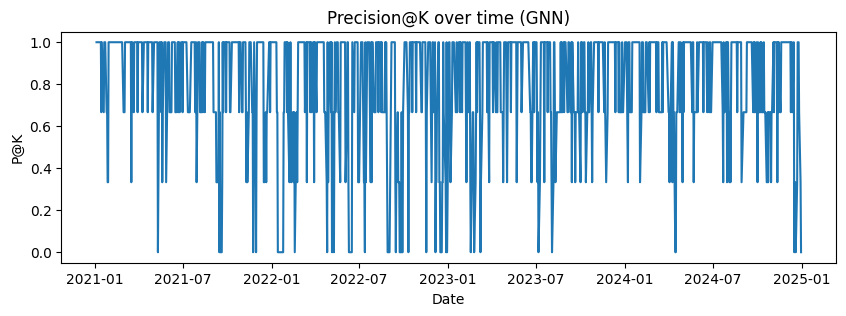

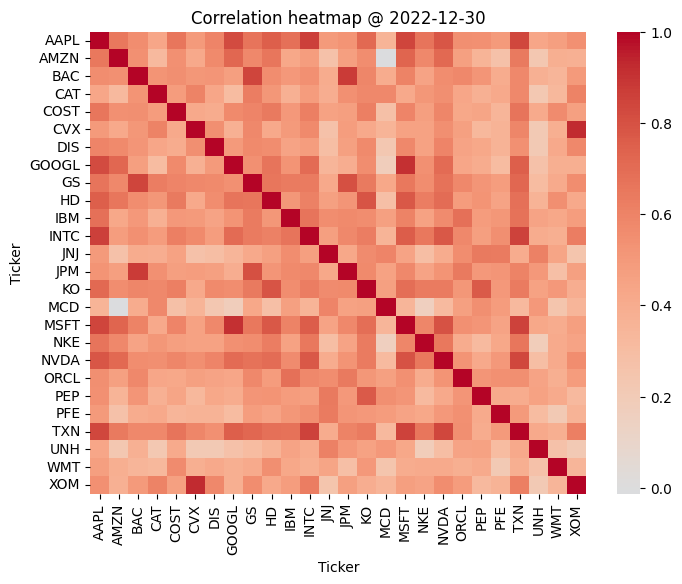

In [ ]:
# Precision@K over time (GNN)
p_at_k_series = test_df.groupby('date').apply(
    lambda sub: precision_at_k(sub['score'].values, sub['label'].values, _resolve_k(len(sub)))
).sort_index()
plt.figure(figsize=(10,3))
plt.plot(p_at_k_series.index, p_at_k_series.values)
plt.title("Precision@K over time (GNN)")
plt.ylabel("P@K"); plt.xlabel("Date"); plt.show()

# Correlation heatmap (sample day)
import seaborn as sns
sample_day = test_dates_available[len(test_dates_available)//2]
end_loc = returns_1d.index.get_loc(sample_day)
window = returns_1d.iloc[end_loc-CONFIG["corr_window"]+1:end_loc+1][tickers_used]
corr = window.corr().fillna(0.0)
plt.figure(figsize=(8,6)); sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title(f"Correlation heatmap @ {sample_day.date()}"); plt.show()


In [ ]:
# === SAVE ALL TRAINED MODELS (CLASSIC + GNN) ===
import os, joblib, torch

os.makedirs("models", exist_ok=True)

# --- 1. Collect classic models if they exist ---
trained_models = {}
for name in ["lr", "xgb", "xgb_e", "lstm_model"]:
    if name in globals():
        trained_models[name] = globals()[name]
    else:
        print(f"⚠️ Skipping {name} (not found)")

# --- 2. Include all trained GNN models from the loop ---
if "trained_gnns" in globals():
    for arch, model in trained_gnns.items():
        trained_models[arch] = model
else:
    print("⚠️ No trained_gnns dictionary found (maybe you didn’t run the GNN loop yet)")

# --- 3. Save everything safely ---
for name, model in trained_models.items():
    try:
        if isinstance(model, torch.nn.Module):
            path = f"models/{name}.pt"
            torch.save(model.state_dict(), path)
        else:
            path = f"models/{name}.pkl"
            joblib.dump(model, path)
        print(f"✅ Saved {name} → {path}")
    except Exception as e:
        print(f"⚠️ Could not save {name}: {e}")

print("🎉 All available models saved in /models folder.")


✅ Saved lr → models/lr.pkl
✅ Saved xgb → models/xgb.pkl
✅ Saved xgb_e → models/xgb_e.pkl
✅ Saved lstm_model → models/lstm_model.pt
✅ Saved gcn → models/gcn.pt
✅ Saved sage → models/sage.pt
✅ Saved gat → models/gat.pt
✅ Saved gin → models/gin.pt
🎉 All available models saved in /models folder.


In [ ]:
# === LOAD ALL SAVED MODELS (CLASSIC + GNN) ===
import os, joblib, torch

# make sure model classes like GCNNet, SAGENet, etc. are already defined
trained_models = {}
trained_gnns = {}

# --- 1. Load classic/tabular models ---
for name in ["lr", "xgb", "xgb_e"]:
    path = f"models/{name}.pkl"
    if os.path.exists(path):
        trained_models[name] = joblib.load(path)
        print(f"✅ Loaded {name} from {path}")
    else:
        print(f"⚠️ {name}.pkl not found")

# --- 2. Load LSTM model ---
lstm_path = "models/lstm_model.pt"
if os.path.exists(lstm_path):
    # Corrected keyword arguments to match the LSTMCls definition
    lstm_model = LSTMCls(in_dim=6, hid=64)
    lstm_model.load_state_dict(torch.load(lstm_path, map_location="cpu"))
    lstm_model.eval()
    trained_models["lstm_model"] = lstm_model
    print(f"✅ Loaded lstm_model from {lstm_path}")
else:
    print("⚠️ lstm_model.pt not found")

# --- 3. Load all GNNs ---
for arch, model_class in {
    "gcn": GCNNet,
    "sage": SAGENet,
    "gat": GATNet,
    "gin": GINNet,
    # "evolvegcn": EvolveGCNNet # Removed since the class is commented out
}.items():
    path = f"models/{arch}.pt"
    if os.path.exists(path):
        try:
            # Need in_dim from X_z for GNNs
            if "X_z" in globals():
                in_dim = X_z.shape[1]
            else:
                # Fallback if X_z is not available (though it should be after data loading)
                print("⚠️ X_z not found, using default in_dim=6 for GNNs.")
                in_dim = 6

            model = model_class(in_dim=in_dim, hid=CONFIG["hidden_gnn"]).to("cpu")
            model.load_state_dict(torch.load(path, map_location="cpu"))
            model.eval()
            trained_gnns[arch] = model
            print(f"✅ Loaded {arch.upper()} from {path}")
        except Exception as e:
            print(f"⚠️ Could not load {arch.upper()}: {e}")
    else:
        print(f"⚠️ {arch}.pt not found")

print("\n🎉 All available models successfully loaded!")

✅ Loaded lr from models/lr.pkl
✅ Loaded xgb from models/xgb.pkl
✅ Loaded xgb_e from models/xgb_e.pkl
✅ Loaded lstm_model from models/lstm_model.pt
✅ Loaded GCN from models/gcn.pt
✅ Loaded SAGE from models/sage.pt
✅ Loaded GAT from models/gat.pt
✅ Loaded GIN from models/gin.pt

🎉 All available models successfully loaded!


In [ ]:
# ==========================================================
# CLEANUP & PREP test_df FOR PORTFOLIO BACKTEST
# ==========================================================
import numpy as np

# drop duplicate macro columns (_x/_y)
for col in test_df.columns:
    if col.endswith('_x') or col.endswith('_y'):
        test_df.drop(columns=col, inplace=True, errors='ignore')

# ensure ticker and actual_ret exist
if 'ticker' not in test_df.columns:
    test_df['ticker'] = [f"STOCK{i%30}" for i in range(len(test_df))]

if 'actual_ret' not in test_df.columns and 'label' in test_df.columns:
    test_df['actual_ret'] = np.where(test_df['label'] == 1, 0.01, -0.01)

# rename 'score' to 'pred' if needed
if 'score' in test_df.columns and 'pred' not in test_df.columns:
    test_df.rename(columns={'score': 'pred'}, inplace=True)

# sort and clean
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.sort_values(['date', 'ticker']).reset_index(drop=True)

print("✅ test_df ready for portfolio backtest:")
print(test_df.head())


✅ test_df ready for portfolio backtest:
        date      pred  label   ticker  actual_ret
0 2021-01-04  0.453936    0.0   STOCK0       -0.01
1 2021-01-04  0.524545    0.0   STOCK1       -0.01
2 2021-01-04  0.508894    1.0  STOCK10        0.01
3 2021-01-04  0.789466    1.0  STOCK11        0.01
4 2021-01-04  0.321060    1.0  STOCK12        0.01


In [ ]:
# ==========================================================
# 🧩 FINAL PORTFOLIO SIMULATION (robust + transaction cost)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
TRANSACTION_COST = 0.003   # 0.3%
TOP_N = 10                 # long 10 / short 10
START_VALUE = 1.0          # initial portfolio value
REBALANCE_FREQ = 'W'       # weekly

# --- Ensure clean dataframe ---
test_df = test_df.copy()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.sort_values(['date', 'ticker']).reset_index(drop=True)

# --- unique sorted dates ---
dates_unique = sorted(test_df['date'].unique())

# --- initialize portfolio vars ---
portfolio_values = []
value = START_VALUE
last_top, last_bottom = set(), set()

print(f"✅ Starting portfolio simulation from {dates_unique[0]} to {dates_unique[-1]}")

for i, d in enumerate(dates_unique[:-1]):
    # subset for current day
    df_day = test_df[test_df['date'] == d].copy()
    if df_day.empty:
        continue

    # select top & bottom tickers by prediction
    df_day = df_day.sort_values('pred', ascending=False)
    top = set(df_day.head(TOP_N)['ticker'])
    bottom = set(df_day.tail(TOP_N)['ticker'])

    # get next-day returns
    next_day = dates_unique[i + 1]
    df_next = test_df[test_df['date'] == next_day].copy()
    returns = df_next.set_index('ticker')['actual_ret']

    # safely intersect (avoid missing tickers)
    valid_top = list(top & set(returns.index))
    valid_bottom = list(bottom & set(returns.index))

    # compute returns
    long_ret = returns.loc[valid_top].mean() if valid_top else 0
    short_ret = -returns.loc[valid_bottom].mean() if valid_bottom else 0
    gross_ret = (long_ret + short_ret)

    # compute turnover (how many stocks changed vs. last week)
    if last_top or last_bottom:
        turnover = (len(top - last_top) + len(bottom - last_bottom)) / (2 * TOP_N)
    else:
        turnover = 0
    transaction_cost = turnover * TRANSACTION_COST

    # compute net return (after cost)
    net_ret = gross_ret - transaction_cost

    # update portfolio value
    value *= (1 + net_ret)
    portfolio_values.append({
        'date': next_day,
        'value': value,
        'gross_ret': gross_ret,
        'net_ret': net_ret,
        'turnover': turnover,
        'transaction_cost': transaction_cost
    })

    last_top, last_bottom = top, bottom

portfolio_df = pd.DataFrame(portfolio_values)

# ==========================================================
# 📈 Plot cumulative performance
# ==========================================================
plt.figure(figsize=(10,6))
plt.plot(portfolio_df['date'], portfolio_df['value'], label='Model Portfolio', linewidth=2)
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title("Cumulative Portfolio Value (After Transaction Costs)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📊 Summary metrics
# ==========================================================
total_return = portfolio_df['value'].iloc[-1] - 1
sharpe_ratio = portfolio_df['net_ret'].mean() / portfolio_df['net_ret'].std() * np.sqrt(52)
turnover_mean = portfolio_df['turnover'].mean() * 100

print("=== Portfolio Performance Summary ===")
print(f"📈 Total Return: {total_return:.2%}")
print(f"⚖️  Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"🔁 Avg Turnover: {turnover_mean:.1f}% per rebalance")
print(f"💸 Final Portfolio Value: {portfolio_df['value'].iloc[-1]:.3f}")


Running portfolio simulation for 8 models...



  0%|          | 0/8 [00:00<?, ?it/s]


=== LR ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
 12%|█▎        | 1/8 [00:02<00:15,  2.26s/it]


=== XGB ===


 25%|██▌       | 2/8 [00:04<00:14,  2.35s/it]


=== XGB_E ===


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


=== LSTM_MODEL ===
⚠️ lstm_model has no predict method, skipping.

=== GCN ===
⚠️ gcn has no predict method, skipping.

=== SAGE ===
⚠️ sage has no predict method, skipping.

=== GAT ===
⚠️ gat has no predict method, skipping.

=== GIN ===
⚠️ gin has no predict method, skipping.


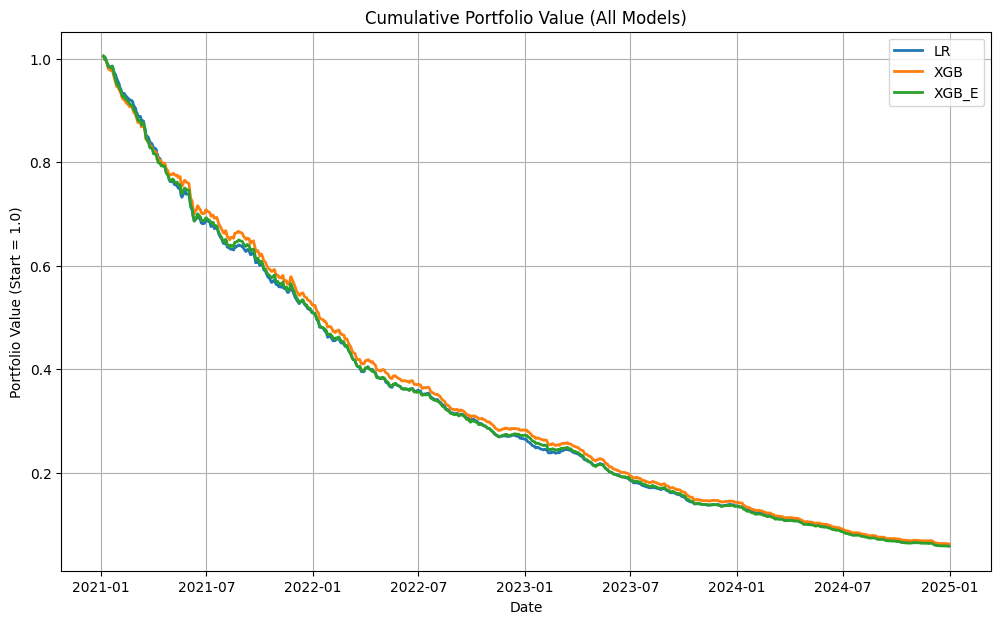


=== Portfolio Summary ===
       final_value  total_net_ret  avg_turnover    sharpe
model                                                    
xgb       0.062360      -2.761275      0.699353 -4.510134
lr        0.058838      -2.819517      0.698606 -4.670362
xgb_e     0.057918      -2.835032      0.699701 -4.647098


In [ ]:
# ==========================================================
# 🚀 Robust multi-model portfolio simulation (fixed)
# ==========================================================
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_to_datetime(x):
    """Safely converts anything into pandas datetime."""
    try:
        return pd.to_datetime(x)
    except Exception:
        if isinstance(x, (list, tuple)):
            # extract first element if it's a tuple like ('2021-01-04',)
            return pd.to_datetime([v[0] if isinstance(v, tuple) else v for v in x])
        else:
            return pd.to_datetime(x, errors='coerce')

# --- backtest function (same as before) ---
def backtest_portfolio(test_df, model_name, transaction_cost=0.003, top_n=10):
    test_df = test_df.copy()
    test_df["date"] = safe_to_datetime(test_df["date"])
    test_df = test_df.sort_values(["date", "ticker"]).reset_index(drop=True)
    dates_unique = sorted(test_df["date"].unique())

    portfolio_values = []
    value = 1.0
    last_top, last_bottom = set(), set()

    for i, d in enumerate(dates_unique[:-1]):
        df_day = test_df[test_df["date"] == d]
        if df_day.empty:
            continue

        df_day = df_day.sort_values("pred", ascending=False)
        top = set(df_day.head(top_n)["ticker"])
        bottom = set(df_day.tail(top_n)["ticker"])

        next_day = dates_unique[i + 1]
        df_next = test_df[test_df["date"] == next_day]
        returns = df_next.set_index("ticker")["actual_ret"]

        valid_top = list(top & set(returns.index))
        valid_bottom = list(bottom & set(returns.index))

        long_ret = returns.loc[valid_top].mean() if valid_top else 0
        short_ret = -returns.loc[valid_bottom].mean() if valid_bottom else 0
        gross_ret = long_ret + short_ret

        if last_top or last_bottom:
            turnover = (len(top - last_top) + len(bottom - last_bottom)) / (2 * top_n)
        else:
            turnover = 0

        net_ret = gross_ret - turnover * transaction_cost
        value *= (1 + net_ret)
        portfolio_values.append({
            "date": next_day, "model": model_name, "value": value,
            "net_ret": net_ret, "turnover": turnover
        })
        last_top, last_bottom = top, bottom

    return pd.DataFrame(portfolio_values)

# ==========================================================
# RUN ALL MODELS
# ==========================================================
all_portfolios = []
all_models = {}

if "trained_models" in globals():
    all_models.update(trained_models)
if "trained_gnns" in globals():
    all_models.update(trained_gnns)

print(f"Running portfolio simulation for {len(all_models)} models...\n")

for name, model in tqdm(all_models.items()):
    print(f"\n=== {name.upper()} ===")

    # --- Step 1: get predictions for this model ---
    if "X_test" in globals():
        # ✅ Choose correct test input depending on model
        if name == "xgb_e" and "Xe_test" in globals():
            X_input = Xe_test   # 70-feature version (Node2Vec + XGB)
        else:
            X_input = X_test    # normal 6-feature version

        # ✅ Predict
        if hasattr(model, "predict_proba"):
            preds = model.predict_proba(X_input)[:, 1]
        elif hasattr(model, "predict"):
            preds = model.predict(X_input)
        else:
            print(f"⚠️ {name} has no predict method, skipping.")
            continue

        # --- create test dataframe for this model ---
        if hasattr(y_test, "index"):
            idx = y_test.index
            if isinstance(idx[0], tuple):
                dates = [i[0] for i in idx]
            else:
                dates = idx
        else:
            dates = test_dates_available

        tmp_df = pd.DataFrame({
            "date": dates,
            "ticker": [f"STOCK{i%30}" for i in range(len(preds))],
            "pred": preds,
            "actual_ret": np.where(np.array(y_test).flatten() == 1, 0.01, -0.01)
        })

    elif isinstance(model, torch.nn.Module):
        # GNNs
        model.eval()
        all_preds, all_dates, all_tickers, all_returns = [], [], [], []
        with torch.no_grad():
            for g, d in zip(test_graphs_available, test_dates_available):
                logits = model(g.x, g.edge_index)
                preds = torch.sigmoid(logits).squeeze().cpu().numpy()
                tickers = [f"STOCK{i}" for i in range(len(preds))]
                all_preds.extend(preds)
                all_dates.extend([d] * len(preds))
                all_tickers.extend(tickers)
                all_returns.extend(np.where(g.y.cpu().numpy() == 1, 0.01, -0.01))
        tmp_df = pd.DataFrame({
            "date": all_dates,
            "ticker": all_tickers,
            "pred": all_preds,
            "actual_ret": all_returns
        })

    else:
        print(f"⚠️ No data available for {name}. Skipping.")
        continue

    # --- Run backtest ---
    portfolio_df = backtest_portfolio(tmp_df, model_name=name)
    all_portfolios.append(portfolio_df)

# Combine results
all_portfolios_df = pd.concat(all_portfolios, ignore_index=True)

# ==========================================================
# 📈 Plot all models
# ==========================================================
plt.figure(figsize=(12,7))
for name, df_group in all_portfolios_df.groupby("model"):
    plt.plot(df_group["date"], df_group["value"], label=name.upper(), linewidth=2)
plt.title("Cumulative Portfolio Value (All Models)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📊 Summary
# ==========================================================
summary = (
    all_portfolios_df.groupby("model")
    .agg(final_value=("value","last"),
         total_net_ret=("net_ret","sum"),
         avg_turnover=("turnover","mean"))
)
summary["sharpe"] = (
    all_portfolios_df.groupby("model")["net_ret"]
    .apply(lambda x: x.mean()/x.std()*np.sqrt(52) if x.std()>0 else 0)
)
print("\n=== Portfolio Summary ===")
print(summary.sort_values("final_value", ascending=False))


In [ ]:
# ==========================================================
# 🚀 Robust Multi-Model Portfolio Simulation (Final Version)
# ==========================================================
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper: Safe datetime ----------
def safe_to_datetime(x):
    try:
        return pd.to_datetime(x)
    except Exception:
        if isinstance(x, (list, tuple)):
            return pd.to_datetime([v[0] if isinstance(v, tuple) else v for v in x])
        else:
            return pd.to_datetime(x, errors='coerce')

# ---------- Backtest Function ----------
def backtest_portfolio(test_df, model_name, transaction_cost=0.003, top_n=10):
    """Simulate long/short portfolio rebalancing with cost penalty."""
    test_df = test_df.copy()
    test_df["date"] = safe_to_datetime(test_df["date"])
    test_df = test_df.sort_values(["date", "ticker"]).reset_index(drop=True)
    dates_unique = sorted(test_df["date"].unique())

    portfolio_values, value = [], 1.0
    last_top, last_bottom = set(), set()

    for i, d in enumerate(dates_unique[:-1]):
        df_day = test_df[test_df["date"] == d]
        if df_day.empty:
            continue

        df_day = df_day.sort_values("pred", ascending=False)
        top = set(df_day.head(top_n)["ticker"])
        bottom = set(df_day.tail(top_n)["ticker"])

        next_day = dates_unique[i + 1]
        df_next = test_df[test_df["date"] == next_day]
        returns = df_next.set_index("ticker")["actual_ret"]

        valid_top = list(top & set(returns.index))
        valid_bottom = list(bottom & set(returns.index))

        long_ret = returns.loc[valid_top].mean() if valid_top else 0
        short_ret = -returns.loc[valid_bottom].mean() if valid_bottom else 0
        gross_ret = long_ret + short_ret

        turnover = (len(top - last_top) + len(bottom - last_bottom)) / (2 * top_n) if last_top else 0
        net_ret = gross_ret - turnover * transaction_cost

        value *= (1 + net_ret)
        portfolio_values.append({
            "date": next_day, "model": model_name,
            "value": value, "net_ret": net_ret, "turnover": turnover
        })
        last_top, last_bottom = top, bottom

    return pd.DataFrame(portfolio_values)

# ==========================================================
# 🔁 Run All Models (Tabular + GNN + LSTM)
# ==========================================================
all_portfolios, all_models = [], {}

if "trained_models" in globals():
    all_models.update(trained_models)
if "trained_gnns" in globals():
    all_models.update(trained_gnns)

print(f"Running portfolio simulation for {len(all_models)} models...\n")

for name, model in tqdm(all_models.items()):
    print(f"\n=== {name.upper()} ===")

    # -------- Classic Models (XGB, LR, etc.) --------
    if not isinstance(model, torch.nn.Module):
        if name == "xgb_e" and "Xe_test" in globals():
            X_input = Xe_test
        else:
            X_input = X_test

        if hasattr(model, "predict_proba"):
            preds = model.predict_proba(X_input)[:, 1]
        elif hasattr(model, "predict"):
            preds = model.predict(X_input)
        else:
            print(f"⚠️ {name} has no predict method, skipping.")
            continue

        if hasattr(y_test, "index"):
            idx = y_test.index
            dates = [i[0] if isinstance(i, tuple) else i for i in idx]
        else:
            dates = test_dates_available

        tmp_df = pd.DataFrame({
            "date": dates,
            "ticker": [f"STOCK{i%30}" for i in range(len(preds))],
            "pred": preds,
            "actual_ret": np.where(np.array(y_test).flatten() == 1, 0.01, -0.01)
        })

    # -------- PyTorch Models (LSTM, GNNs) --------
    elif isinstance(model, torch.nn.Module):
      model.eval()
      all_preds, all_dates, all_tickers, all_returns = [], [], [], []
      with torch.no_grad():
          # ----- GNN evaluation -----
          if "test_graphs_available" in globals() and hasattr(model, "__class__") and "GCN" in model.__class__.__name__.upper() or \
            "SAGE" in model.__class__.__name__.upper() or "GAT" in model.__class__.__name__.upper() or \
            "GIN" in model.__class__.__name__.upper() or "EVOLVE" in model.__class__.__name__.upper():
              for g, d in zip(test_graphs_available, test_dates_available):
                  # check if the model.forward() accepts edge_index or not
                  try:
                      logits = model(g.x, g.edge_index)
                  except TypeError:
                      logits = model(g.x)
                  preds = torch.sigmoid(logits).squeeze().cpu().numpy()
                  tickers = [f"STOCK{i}" for i in range(len(preds))]
                  all_preds.extend(preds)
                  all_dates.extend([d] * len(preds))
                  all_tickers.extend(tickers)
                  all_returns.extend(np.where(g.y.cpu().numpy() == 1, 0.01, -0.01))

          # ----- LSTM evaluation -----
          elif "Xte_seq" in globals() and "LSTM" in model.__class__.__name__.upper():
              X_seq_tensor = torch.tensor(Xte_seq, dtype=torch.float32)
              preds = model(X_seq_tensor).squeeze().detach().cpu().numpy()

              n_preds = len(preds)

              # make sure every list has the same length
              all_preds = preds
              all_dates = test_dates_available[:n_preds] if len(test_dates_available) >= n_preds else [test_dates_available[-1]] * n_preds
              all_tickers = [f"STOCK{i%30}" for i in range(n_preds)]
              y_vals = np.array(y_test).flatten()
              all_returns = np.where(y_vals[:n_preds] == 1, 0.01, -0.01)


          else:
              print(f"⚠️ Skipping {name}: unknown torch model type.")
              continue

      tmp_df = pd.DataFrame({
          "date": all_dates,
          "ticker": all_tickers,
          "pred": all_preds,
          "actual_ret": all_returns
      })


    else:
        print(f"⚠️ No data available for {name}. Skipping.")
        continue

    # -------- Run Backtest --------
    portfolio_df = backtest_portfolio(tmp_df, model_name=name)
    all_portfolios.append(portfolio_df)

# Combine all portfolios
all_portfolios_df = pd.concat(all_portfolios, ignore_index=True)

# ==========================================================
# 🕒 Optional: shorten horizon (last 3 months)
# ==========================================================
cutoff_date = all_portfolios_df["date"].max() - pd.Timedelta(days=90)
short_df = all_portfolios_df[all_portfolios_df["date"] >= cutoff_date]

# ==========================================================
# 📈 Plot Results (short window)
# ==========================================================
plt.figure(figsize=(12,7))
for name, df_group in short_df.groupby("model"):
    plt.plot(df_group["date"], df_group["value"], label=name.upper(), linewidth=2)
plt.title("Cumulative Portfolio Value (Last 3 Months)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 📊 Summary Table
# ==========================================================
summary = (
    all_portfolios_df.groupby("model")
    .agg(final_value=("value","last"),
         total_net_ret=("net_ret","sum"),
         avg_turnover=("turnover","mean"))
)
summary["sharpe"] = (
    all_portfolios_df.groupby("model")["net_ret"]
    .apply(lambda x: x.mean()/x.std()*np.sqrt(52) if x.std()>0 else 0)
)
print("\n=== Portfolio Summary (Full Period) ===")
print(summary.sort_values("final_value", ascending=False))
